- In the last approach we reduced edges by skimming them based on IoU
- Here we will introduce some additional nodes that gives significant edge reduction

In [4]:
import re
import urllib.request
import openpyxl
import requests
import pandas as pd
import os.path

In [7]:
main_url = "https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/"

def parseForDownloadUrls():
    links = []
    resp = requests.get(main_url)
    page_str = str(resp.content)

    for word in page_str.split():
        # print(word)
        s = str(word)
        pattern = 'href=".*xlsx'
        mat = re.search(pattern, s)
        if mat:
            links.append(main_url+mat.group().split('"')[1])
    return links

def downloadUrls(link):

    out_filename = link.split('/')[-1].split('.')[0].replace("%20", " ")+'.csv'
    if os.path.isfile(out_filename):
        print('file exsists', out_filename)
    else:
        df = pd.read_excel(link)
        df.drop(df.index[:8], inplace=True)
        df = df.iloc[:,1:5]
        df = df.reset_index(drop = True)
        df.index += 1
        df.to_csv(out_filename)
        print('downloaded', out_filename)
    return out_filename

In [8]:

download_urls = parseForDownloadUrls()
print("These are the obtained links:-")
for i in range(len(download_urls)):
    print(i+1,"-",download_urls[i])

downloaded_files = []

for url in download_urls:
    try:
        filename = downloadUrls(url)
        downloaded_files.append(filename)

    except:
        print('cannot download', url)

These are the obtained links:-
1 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS2002%20Computer%20Organization%20and%20Architecture.xlsx
2 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS2003%20Database%20Management%20Systems.xlsx
3 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS2004%20Introduction%20to%20Data%20Science.xlsx
4 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS3009-Network%20Security%20&amp;%20Cryptography.xlsx
5 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS3010-Software%20Engineering.xlsx
6 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS3011-Artificial%20Intelligence.xlsx
7 - https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS8004-Deep%20Learning%20and%20Applications.xlsx
8 

cannot download https://www.iiitdmj.ac.in/admission.iiitdmj.ac.in/Roll%20List%20for%20Sem-I,%202022-23/CS3009-Network%20Security%20&amp;%20Cryptography.xlsx
file exsists CS3010-Software Engineering.csv
file exsists CS3011-Artificial Intelligence.csv
file exsists CS8004-Deep Learning and Applications.csv
file exsists CS8007-Social Network Analysis.csv
file exsists CS8016-Cloud Computing.csv
file exsists CS8017-Intrusion Detection Systems.csv
file exsists CS8018-Web Mining.csv
file exsists CS8023-Software Defined Networking.csv
file exsists DS2005 Studies in Form.csv
file exsists DS2006 Industrial Design 1.csv
file exsists DS2007 Communication Design 1.csv
file exsists DS2008 Design Project 1.csv
file exsists DS2010 Material and Processes.csv
file exsists DS3001-Engineering Design  Including Design and Fabrication Project.csv
file exsists DS3009-Service Design.csv
file exsists DS3010-Sustainable Design.csv
file exsists DS3011-Design Management.csv
file exsists DS3012-Design Project 4.csv

In [9]:
print(len(downloaded_files))

131


In [10]:
# student_data = {'roll': {'name':, 'branch':, 'courses': [], 'email': }}
student_data = {}
for filename in downloaded_files:
  try:
    df = pd.read_csv(filename)
  except:
    print('cannt open file', filename)
  course_name = filename.split('.')[0]
  for ind in df.index:
    roll = str(df['Unnamed: 1'][ind]).strip()
    if roll in student_data:
      student_data[roll]['courses'].append(course_name)
    else:
      student_data[roll] = {'name': str(df['Unnamed: 2'][ind]), 'branch': str(df['Unnamed: 3'][ind]), 'courses': [course_name]}


In [11]:
print(len(student_data))

1498


In [12]:
import networkx as nx
import matplotlib.pyplot as plt


In [13]:
G = nx.Graph()
for c in downloaded_files:
  course_name = c.split('.')[0]
  G.add_node(course_name, label='COURSE')

for k in list(student_data.keys()):
  G.add_node(str(k), label='STUD')
  for c in student_data[str(k)]['courses']:
    G.add_edge(str(k), c)


In [14]:
import matplotlib.pyplot as plt

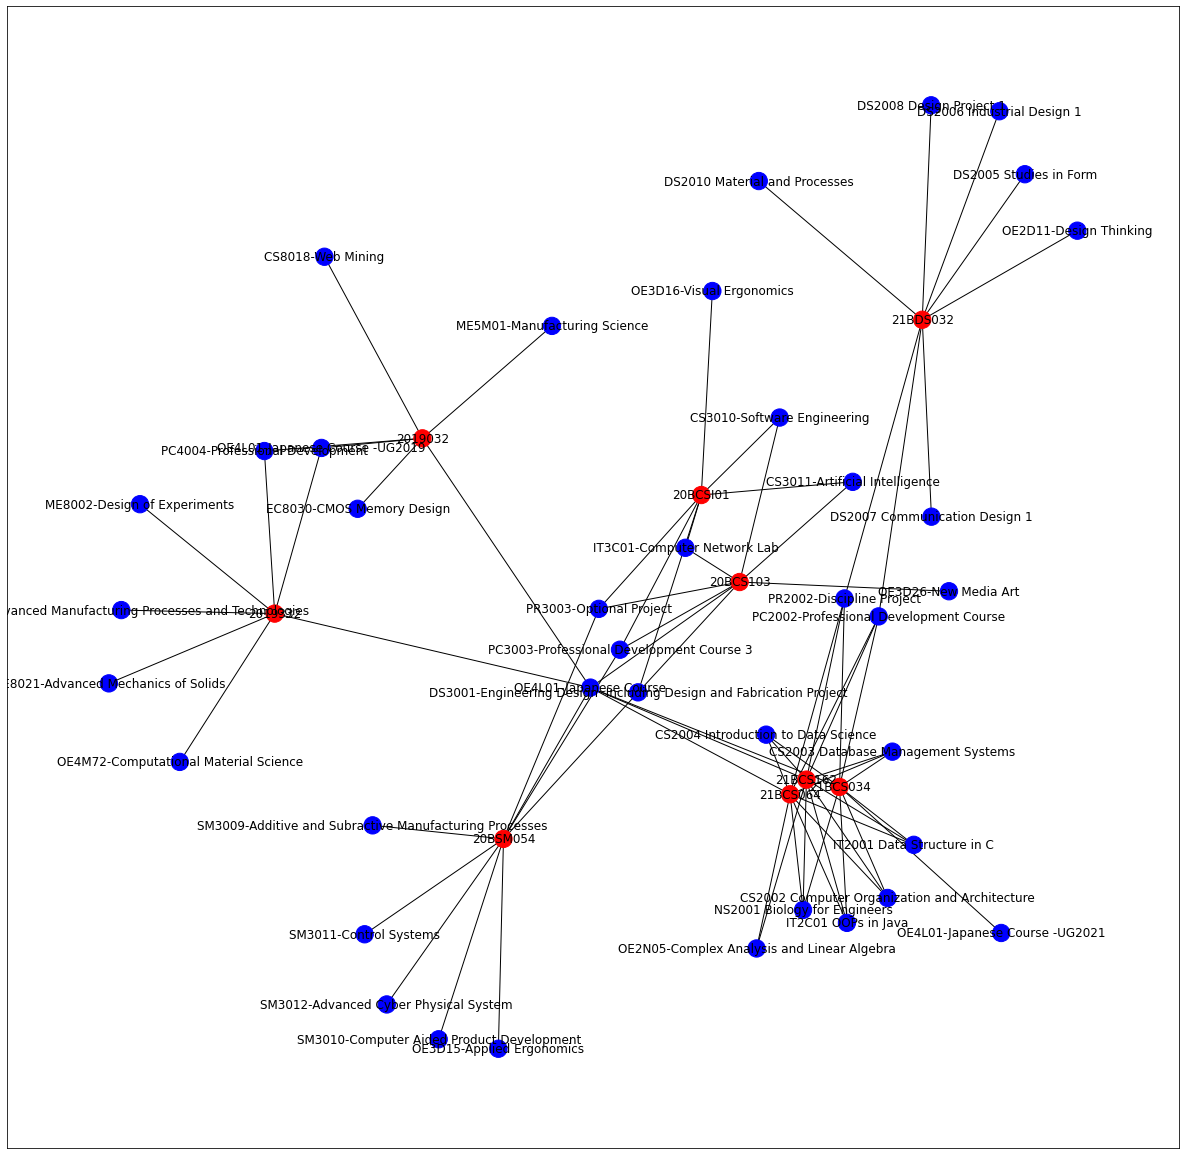

In [17]:
import random
course_node = []
student_node = []
for n in G.nodes():
    if G.nodes()[n]['label'] == 'COURSE':
        course_node.append(n)
    elif G.nodes()[n]['label'] == 'STUD':
        student_node.append(n)

random.shuffle(student_node)

Gs = G.subgraph(course_node + student_node[:10])
Gcc = sorted(nx.connected_components(Gs), key=len, reverse=True)
Gs = Gs.subgraph(Gcc[0])
colors = []

for n in Gs.nodes():
    if Gs.nodes()[n]['label'] == 'COURSE':
        colors.append('blue')
    elif Gs.nodes()[n]['label'] == 'STUD':
        colors.append('red')

plt.rcParams['figure.figsize'] = [21,21]
pos = nx.spring_layout(Gs, k = 0.15, iterations=20) 
nx.draw_networkx(Gs, pos, with_labels=True, node_color = colors)

plt.show()

In [18]:
print(G.number_of_nodes(), G.number_of_edges())

1629 11816


- Getting similar nodes using Adamic Adar Method

In [19]:
import math
import numpy as np
def get_similar(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="STUD":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    students=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        students.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=students)
    result.sort_values(inplace=True,ascending=False)        
    return result

In [20]:
target_roll = "2019174"
topk = 10

result = get_similar(target_roll)
print('similar to', target_roll, student_data[target_roll]['name'])
print('-------------------------------------')
similar_stud = list(zip(result.index, result))[:topk]
# print(similar_stud)
for roll, w in similar_stud:
    print(roll, student_data[str(roll)]['name'], w)


similar to 2019174 VIRAL NIRAJ
-------------------------------------
2019029 ANKIT SHARMA 1.202009700232025
2019099 NISHIKET BIDAWAT 1.202009700232025
2019104 PARTH SAKARIYA 1.202009700232025
2019194 AKHILESH DIGAMBAR 0.9857922130442718
2019275 KSHITIJ SANWAL 0.9857922130442718
2019209 ANSH NAHAR 0.9857922130442718
2019198 ALLAM NIKHIL 0.9857922130442718
2019345 SRIKAKULAPU V 0.9696712066579076
2019143 SANDEEP SOLANKI 0.9696712066579076
2019189 ADARSH KUMAR 0.9309246695502085


In [21]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)

def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="COURSE":
            colors.append('blue')
        elif G.nodes[e]['label']=="STUD":
            colors.append('red')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

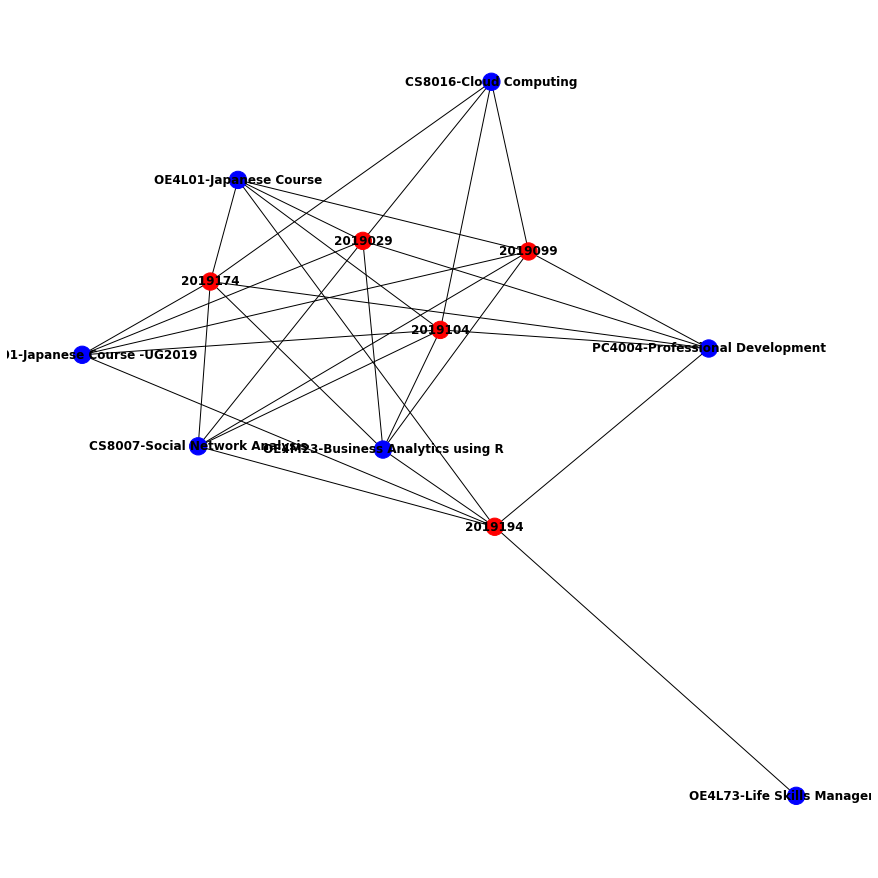

In [22]:
plt.rcParams['figure.figsize'] = [12,12]

reco=list(result.index[:4].values)
reco.extend([target_roll])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

In [23]:
from networkx.algorithms.community.centrality import girvan_newman

def plt_community(G):
    communities = girvan_newman(G)
    node_groups = []
    for com in next(communities):
        node_groups.append(list(com))
    
    # print(node_groups)

    color_map = []
    for node in G:
        if node in node_groups[0]:
            color_map.append('blue')
        else:
            color_map.append('green')

    plt.rcParams['figure.figsize'] = [28,28]
    pos = nx.spring_layout(G, k=0.5, iterations=20) # pos = nx.nx_agraph.graphviz_layout(G)
    nx.draw_networkx(G, pos, with_labels=True, node_color=color_map)

    # nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()

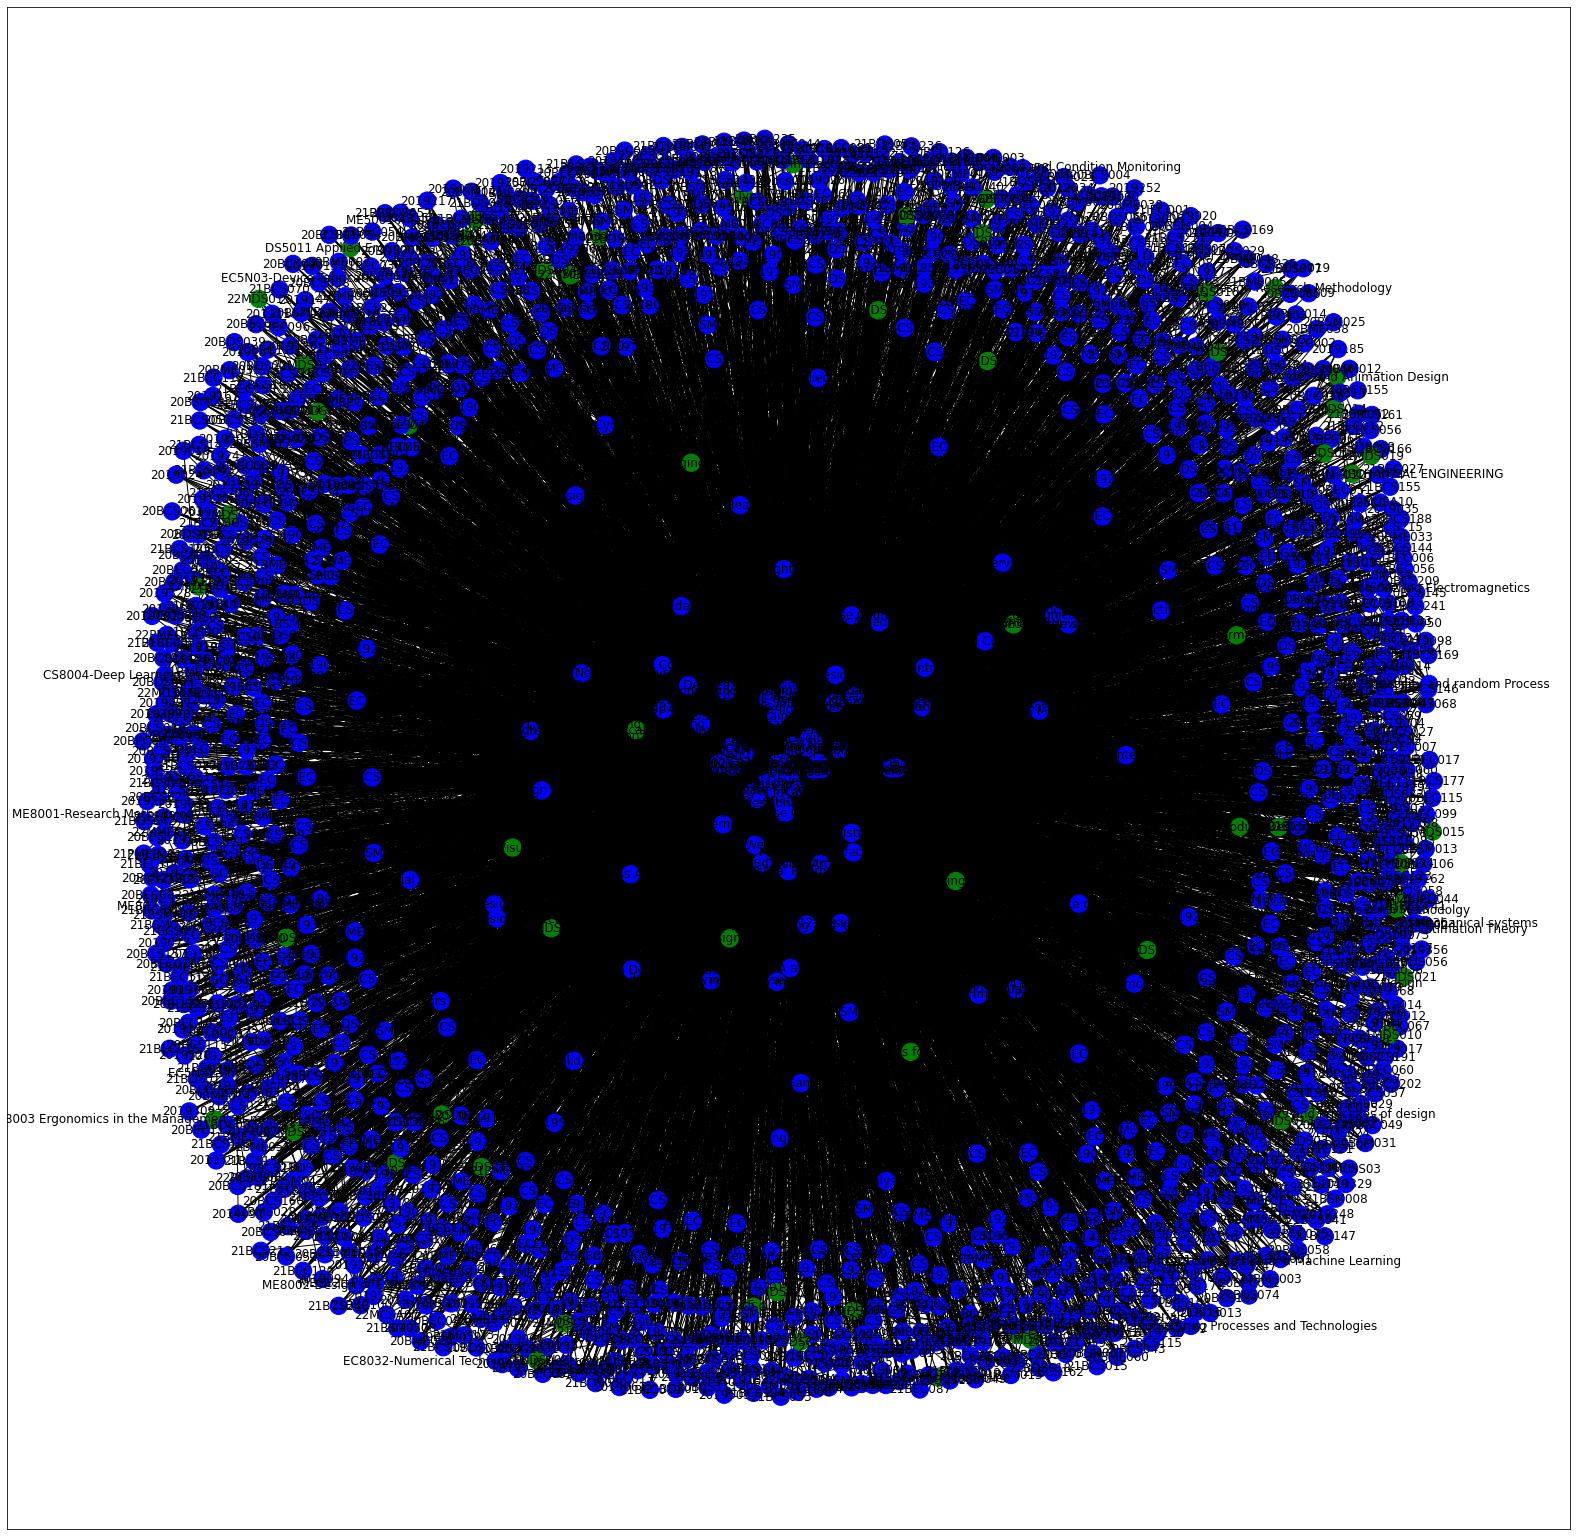

In [24]:
plt_community(G)

In [25]:
import random
sgl = list(G.nodes())
random.shuffle(sgl)
Gs = G.subgraph(sgl[:200])
communities = girvan_newman(Gs)
node_groups = []
for com in next(communities):
    node_groups.append(list(com))
print(node_groups)

[['21BCS093', '21BCS113', '20BSM005', '20BCS010', '21BSM042', '21BCS072', '21BCS207', '21BSM023', '21BCS246', '21BSM032', '21BEC001', '20BSM057', '20BSM046', '21BCS135', '21BCS219', '21BCS188', 'OE3M27-Vibration of Mechanical systems', '21BCS210', '21BCS171', '21BCS224', '21BCS237', '21BCS102', '21BCS077', '21BCS044', '21BCS154', '21BCS192', '21BCS250', '21BCS181', 'OE2N05-Complex Analysis and Linear Algebra', '21BSM015', '20BSM029', '21BCS081', '21BCS208', '21BCS173', '20BME033', '21BCS097', '21BCS066', '21BCS241', '21BCS055', '21BSM040', '21BSM039', '21BCS200', '21BSM059', '21BCS018', 'SM3010-Computer Aided Product Development', 'CS2003 Database Management Systems', '21BCS024', '21BCS053', '20BME053', 'IT2S01 Drawing_Drafting_Modelling and kinematic dynamic modelling', '21BSM061', '21BCS086', '21BCS073', '21BCS014', 'OE2C10 Game Theory'], ['21BEC105'], ['20BCS198'], ['20BCS087'], ['20BSM010'], ['2019084', '2019131', '2019266', '2019087', '2019042', '2019094', '2019150', '2019007', '2